# Health Care Project — Modeling
Goal: Predict the likelihood of having a heart attack based on several health-related features.

In [75]:
import pandas as pd
import numpy as np 
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix



In [76]:
import requests
import io

url = 'https://raw.githubusercontent.com/ahmedsameh909/Health-Care-Project/Ahmed_branch/Data_Heart_clean.csv'
response = requests.get(url)
Data = pd.read_csv(io.StringIO(response.text))

## Data Overview
- Target Variable: HadHeartAttack (0 = No, 1 = Yes)
- Type: Binary classification
- Numeric Columns: PhysicalHealthDays, MentalHealthDays, SleepHours, HadAngina, HadStroke, etc.
- Observation: The dataset is imbalanced (around 95% No, 5% Yes).

Before modeling, data cleaning and preprocessing were completed:
- Missing values handled
- Data types fixed
- Numeric columns selected

In [77]:
numeric_df = Data.select_dtypes(include=[np.number])
numeric_df.describe()

,PhysicalHealthDays,MentalHealthDays,SleepHours,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,...,DifficultyErrands,ChestScan,HeightInMeters,WeightInKilograms,BMI,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear
count,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000,273614.00000,273614.000000,...,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000
mean,4.058857,4.088223,6.994606,0.052932,0.059412,0.039910,0.147580,0.084279,0.07549,0.200187,...,0.065223,0.418381,1.703554,83.356910,28.647040,0.339606,0.527579,0.402216,0.663234,0.041646
std,8.354704,8.045344,1.251049,0.223899,0.236395,0.195749,0.354684,0.277807,0.26418,0.400141,...,0.246920,0.493294,0.105620,20.806568,6.406451,0.473576,0.499240,0.490346,0.472605,0.199780
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.910000,22.680000,6.770000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,1.630000,68.040000,24.340000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,1.700000,81.650000,27.720000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,3.000000,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,1.000000,1.780000,93.890000,31.830000,1.000000,1.000000,1.000000,1.000000,0.000000
max,30.000000,30.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,...,1.000000,1.000000,2.410000,292.570000,117.220000,1.000000,1.000000,1.000000,1.000000,1.000000


In [78]:
numeric_df['HadHeartAttack'].value_counts()
print((numeric_df['HadHeartAttack'].value_counts(normalize=True)*100).round(2))

HadHeartAttack
0    94.71
1     5.29
Name: proportion, dtype: float64


## Feature Selection
- I used correlation analysis to identify which features have the highest relationship with the target.
- The top correlated features were chosen:
  - HadAngina
  - HadStroke
  - ChestScan
  - DifficultyWalking
  - HadDiabetes
  - HadCOPD
  - PhysicalHealthDays
  - PneumoVaxEver
  - HadArthritis
  - HadKidneyDisease

These features were selected because:
- They showed the strongest correlation with HadHeartAttack.
- They make medical sense (related to heart and chronic health conditions).

C:\Users\shiko\AppData\Local\Temp\ipykernel_23928\3139261000.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




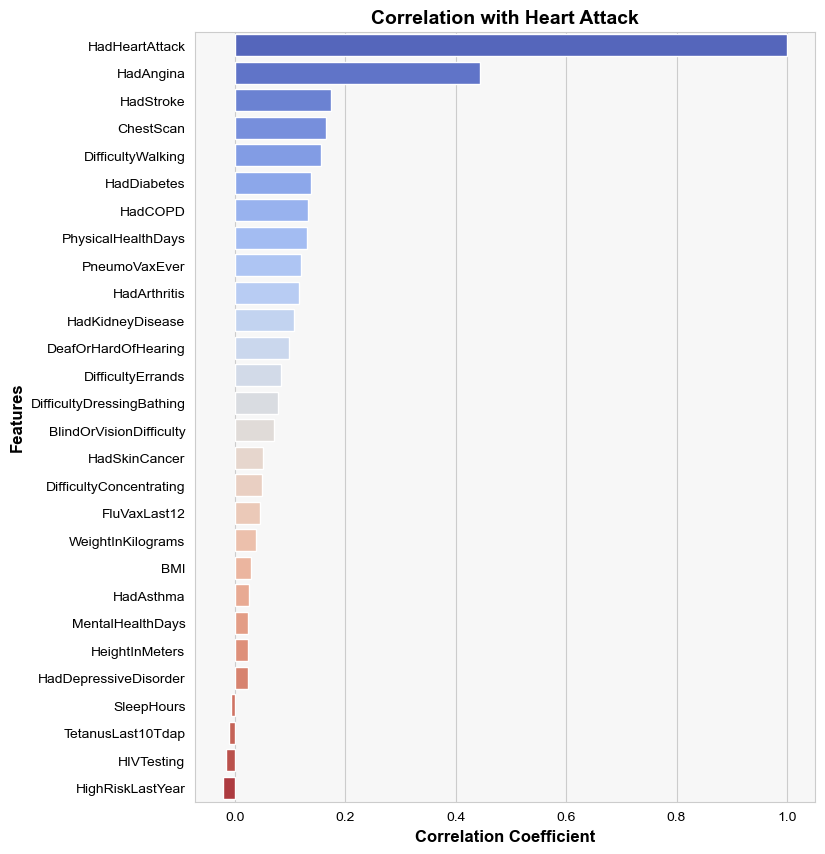

In [79]:

corr = numeric_df.corr()['HadHeartAttack'].sort_values(ascending=False)
plt.figure(figsize=(8,10))
sns.barplot(x=corr, y=corr.index, palette='coolwarm')
plt.title('Correlation with Heart Attack', fontsize=14, weight='bold')
plt.xlabel('Correlation Coefficient', fontsize=12, weight='bold')
plt.ylabel('Features', fontsize=12, weight='bold')
plt.show()

In [80]:
features = ['HadAngina','HadStroke','ChestScan','DifficultyWalking','HadDiabetes','HadCOPD','PhysicalHealthDays','PneumoVaxEver','HadArthritis','HadKidneyDisease']
target =['HadHeartAttack']

## Train/Test Split
We divided the dataset into training and testing sets using an 80/20 ratio.

X = `features` 

y = `HadHeartAttack`


In [81]:
x= numeric_df[features]
y= numeric_df[target]
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=42, stratify=y)

## Handling Imbalanced Data
Since 95% of the samples are negative (0), we used:
- `class_weight='balanced'` in Logistic Regression to automatically assign higher weight to the minority class (1).
- This helps the model focus more on detecting heart attack cases.

In [82]:
model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
model.fit(x_train, y_train)

c:\Users\shiko\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [83]:
y_pred = model.predict(x_test)

## Predictions and Model Evaluation

After training, we evaluated the model using Accuracy, Classification Report, and Confusion Matrix.


In [84]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", round((acc)*100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 84.56 %

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.85      0.91     51826
           1       0.21      0.72      0.33      2897

    accuracy                           0.85     54723
   macro avg       0.60      0.79      0.62     54723
weighted avg       0.94      0.85      0.88     54723



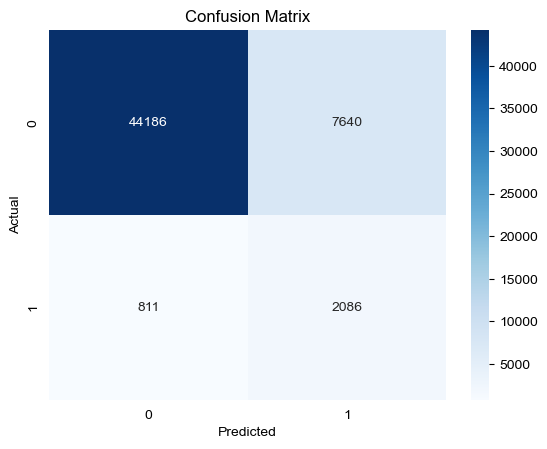

In [85]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()